In [ ]:
# install pyspark
%%bash
pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=76becfd2d0a36eeee94875aff3984d1c4b3f87734dd2ecf68752fa006e505a7d
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
# all needed imports
import os
from pyspark.sql import SparkSession, SQLContext, types, functions as fn, Row
from pyspark.sql.functions import substring, regexp_extract, concat, count, avg, when, col, lower, concat_ws 
from pyspark.ml import feature, regression, evaluation, Pipeline, clustering
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier

from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as mce, ClusteringEvaluator, BinaryClassificationEvaluator as bce
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler, StandardScaler, PCA, ChiSqSelector, StringIndexer, OneHotEncoder
from matplotlib import pyplot as plt
from google.colab import files
import seaborn as sns
import pandas as pd
import numpy as np
import requests

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [ ]:
# import raw data
raw_data = '/content/gdrive/My Drive/ist718_data/data_group4/renttherunway_final_data.json'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# You must use the definitions above to load your data.
data_df=sqlContext.read.json(raw_data)

Mounted at /content/gdrive


In [ ]:
# read raw data 
#data_df=sqlContext.read.json("/content/gdrive/My Drive/data/renttherunway_final_data.json")

# Part 1: Data Preprocessing

In [ ]:
# reformat weight and height 
data_df=data_df.withColumn("weights",substring("weight",1,3))
data_df=data_df.drop("weight")
data_df = data_df.withColumn("heights",fn.round((regexp_extract('height','(\d)..(\d)',1)*30.48+regexp_extract('height','(\d)..(\d)',2)*2.54),2))
data_df = data_df.drop("height")

# change datatype
data_df=data_df.withColumn("age",data_df["age"].cast(types.IntegerType()))
data_df=data_df.withColumn("rating",data_df["rating"].cast(types.IntegerType()))
data_df=data_df.withColumn("size",data_df["size"].cast(types.DoubleType()))
data_df=data_df.withColumn("weights",data_df["weights"].cast(types.DoubleType()))
data_df=data_df.withColumn("heights",data_df["heights"].cast(types.DoubleType()))
data_df=data_df.drop("review_date","_corrupt_record","item_id","user_id")

# rename column
data_df=data_df.withColumnRenamed("body type","body_type")
data_df=data_df.withColumnRenamed("bust size","bust_size")
data_df=data_df.withColumnRenamed("rented for","rented_for")

# remove unusual value
data_df=data_df.filter(data_df.age<100)
data_df=data_df.filter(data_df.age>12)

In [ ]:
# check missing values
data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in data_df.columns]).show()

+---+---------+---------+--------+---+------+----------+--------------+-----------+----+-------+-------+
|age|body_type|bust_size|category|fit|rating|rented_for|review_summary|review_text|size|weights|heights|
+---+---------+---------+--------+---+------+----------+--------------+-----------+----+-------+-------+
|  0|    14075|    18346|       0|  0|    81|        10|             0|          0|   0|  30073|    668|
+---+---------+---------+--------+---+------+----------+--------------+-----------+----+-------+-------+



In [ ]:
# remove records with missing values in rating, review_text and review_summary
data_df = data_df.where(col('rating').isNotNull())
data_df = data_df.where(col('review_text').isNotNull())
data_df = data_df.where(col('review_summary').isNotNull())

# subsititude null value in size, weights and heights with average values
ave_weight = round(data_df.groupBy().avg('weights').head()[0],3)
ave_height = round(data_df.groupBy().avg('heights').head()[0],3)
ave_size = round(data_df.groupBy().avg('size').head()[0],0)

data_df = data_df.fillna(ave_weight,subset = 'weights')
data_df = data_df.fillna(ave_height, subset = 'heights')
data_df = data_df.fillna(ave_size, subset = 'size')

In [ ]:
# check the most common bust_size
data_df.orderBy("bust_size", ascending = False).take(1)

[Row(age=30, body_type='athletic', bust_size='48dd', category='dress', fit='fit', rating=6, rented_for='other', review_summary='Beautiful dress....but you can tell it is really worn.', review_text="It is a beautiful dress; however, the top button was dangling when I went to put it on and it broke. I ended up having to use a safety pin. There was also a small tear in the bottom backside of the dress. Plus the zipper was really hard to maneuver (not that is was too tight, but that it was worn out). Overall, if I saw this dress in a store and could afford it I would buy it in a heart beat, but I wouldn't rent it again. ", size=28.0, weights=185.0, heights=167.64)]

In [ ]:
# check the most common bust_size
data_df.orderBy("bust_size", ascending = False).take(1)

[Row(age=30, body_type='athletic', bust_size='48dd', category='dress', fit='fit', rating=6, rented_for='other', review_summary='Beautiful dress....but you can tell it is really worn.', review_text="It is a beautiful dress; however, the top button was dangling when I went to put it on and it broke. I ended up having to use a safety pin. There was also a small tear in the bottom backside of the dress. Plus the zipper was really hard to maneuver (not that is was too tight, but that it was worn out). Overall, if I saw this dress in a store and could afford it I would buy it in a heart beat, but I wouldn't rent it again. ", size=28.0, weights=185.0, heights=167.64)]

In [ ]:
# fill null values in body_type, bust_size and rented_for with the most common value
data_df = data_df.fillna('hourglass',subset = 'body_type')
data_df = data_df.fillna('44f',subset = 'bust_size')
data_df = data_df.fillna('work',subset = 'rented_for')

In [ ]:
# check missing values again
data_df.select([count(when(col(c).isNull(), c)).alias(c) for c in data_df.columns]).show()

+---+---------+---------+--------+---+------+----------+--------------+-----------+----+-------+-------+
|age|body_type|bust_size|category|fit|rating|rented_for|review_summary|review_text|size|weights|heights|
+---+---------+---------+--------+---+------+----------+--------------+-----------+----+-------+-------+
|  0|        0|        0|       0|  0|     0|         0|             0|          0|   0|      0|      0|
+---+---------+---------+--------+---+------+----------+--------------+-----------+----+-------+-------+



In [ ]:
# compute total count for body_type and rating 
body_type_df1=data_df.groupBy(data_df.body_type).count().toPandas()
rating_df1=data_df.groupBy(data_df.rating).count().toPandas()

In [ ]:
# define function to draw bar plot
def draw_bar(dataframe,column):
    plt.figure()
    p1 = dataframe.plot(kind='bar', x=column, width =1,fontsize = 8, edgecolor='black')
    p1.set_xlabel('%s '%column)
    p1.set_ylabel('count')
    plt.xticks(rotation=45)
    p1.set_title('Total count for %s'%column)

<Figure size 432x288 with 0 Axes>

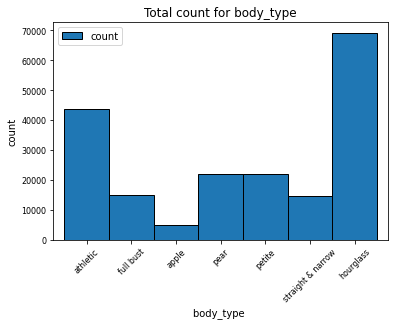

<Figure size 432x288 with 0 Axes>

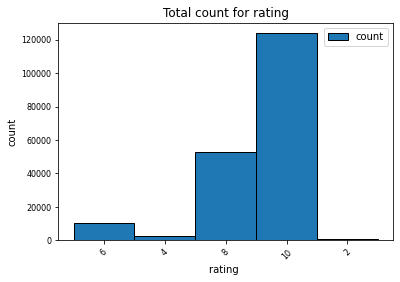

In [ ]:
# bar plot 
draw_bar(body_type_df1,"body_type")
draw_bar(rating_df1,"rating")

<Figure size 432x288 with 0 Axes>

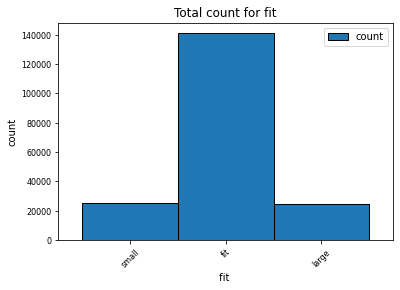

<Figure size 432x288 with 0 Axes>

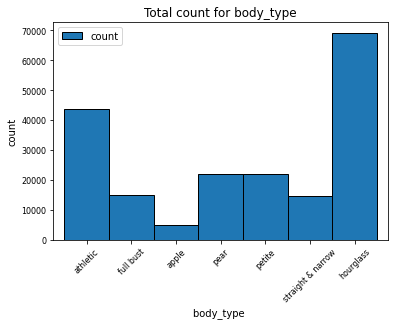

<Figure size 432x288 with 0 Axes>

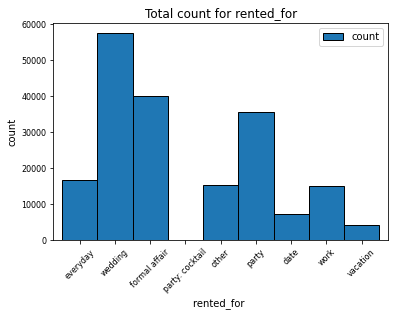

In [ ]:
# data exploration
draw_bar(data_df.groupby(data_df.fit).count().toPandas(),'fit')
draw_bar(data_df.groupby(data_df.body_type).count().toPandas(),'body_type')
draw_bar(data_df.groupby(data_df.rented_for).count().toPandas(),'rented_for')

Text(0.5, 1.0, 'Total count for top ten category')

<Figure size 432x288 with 0 Axes>

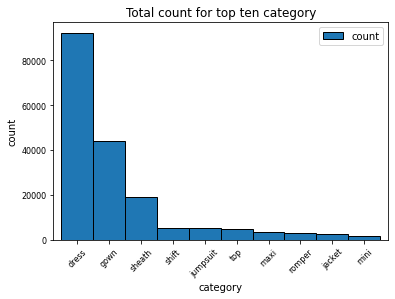

In [ ]:
# top 10 category
category_count = data_df.groupby(data_df.category).count().sort('count',ascending = False).toPandas()[:10]
plt.figure()
p1 = category_count.plot(kind='bar', x='category', width =1,fontsize = 8, edgecolor='black')
p1.set_xlabel('category')
p1.set_ylabel('count')
plt.xticks(rotation=45)
p1.set_title('Total count for top ten category')

Text(0.5, 1.0, 'Age Distribution')

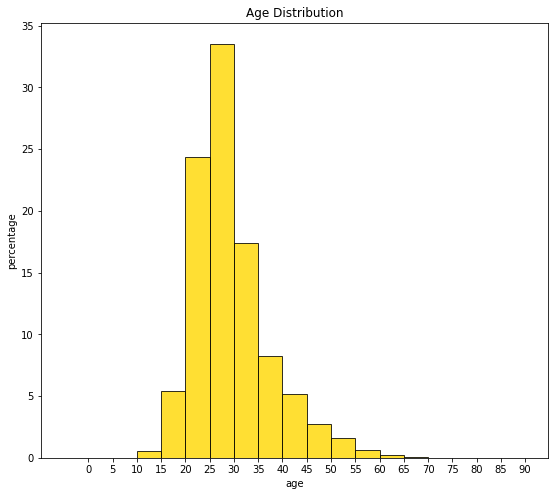

In [ ]:
# data exploration of 'age'
var = 'age'
x = data_df.select(var).toPandas()[var]
bins = np.arange(0, 100, 5.0)
hist, bin_edges = np.histogram(x,bins,weights=np.zeros_like(x) + 100. / x.size)
# make the histogram

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black', color='gold')
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)])
# Set the xticklabels to a string that tells us what the bin edges were
labels =['{}'.format(int(bins[i+1])) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
plt.xlabel(var)
plt.ylabel('percentage')
plt.title('Age Distribution')

# Part 2: Sentiment Analysis

In [ ]:
## prediction 1
# reformat weight and height 

# set rating that lower than or equal 5 to logical value 0, rating that greater than 5 to logical value 1
data_df_senti = data_df.withColumn('attitude', when(data_df['rating'] > 5, 1).otherwise(0))

training_df, validation_df, testing_df = data_df_senti.randomSplit([0.6, 0.3, 0.1], seed=0)

# tokenize function
tokenizer = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("review_text").setOutputCol("words")

# remove stop words function
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words_remover = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("words_cleaned")

# create a countvectorizer transformer
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17).setInputCol("words_cleaned").setOutputCol("tf")

# TF-IDF function
idf = IDF(inputCol="tf", outputCol="tf_idf")


# create a pipeline to tokenize, remove stop words, and do a TF-IDF transformation.
pipe_senti_1 = Pipeline(stages = [tokenizer, stop_words_remover, cv, idf])


In [ ]:
# import original logistic regression model
lr = LogisticRegression().setLabelCol("attitude").setFeaturesCol("tf_idf")
lr_pipe = Pipeline(stages = [pipe_senti_1, lr])
lr_fit = lr_pipe.fit(training_df)

pipeline_model_1 = pipe_senti_1.fit(training_df)

# Score the original model using ROC AUC
evaluator = evaluation.BinaryClassificationEvaluator(labelCol = "attitude")
lr_auc = evaluator.evaluate(lr_fit.transform(testing_df)) 
print("the resulting AUC is", lr_auc, "!!!")

the resulting AUC is 0.787123381667565 !!!


In [ ]:
# set enable_grid to True or False
enable_grid = True

In [ ]:
# improve the model
from pyspark.ml.tuning import ParamGridBuilder

# find the best model
if enable_grid:
    # grid search code
    lr_pipe_1 = lr_pipe
    grid = ParamGridBuilder().addGrid(lr.regParam, [0., 0.01, 0.02]).addGrid(lr.elasticNetParam, [0., 0.2, 0.4]).build()
    all_models = []
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = lr_pipe_1.fit(training_df, grid[j])
        all_models.append(model)
    # estimate the accuracy of each of them:
    accuracies = [m.\
        transform(validation_df).\
        select(fn.avg(fn.expr('float(attitude = prediction)')).alias('accuracy')).\
        first().\
        accuracy for m in all_models]

    best_model_idx = np.argmax(accuracies)
    print("best model index =", best_model_idx)

    print(grid[best_model_idx])
    best_model = all_models[best_model_idx]
    best_model.\
        transform(testing_df).\
        select(fn.avg(fn.expr('float(attitude = prediction)')).alias('accuracy')).\
        show() 
    pass

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
best model index = 4
{Param(parent='LogisticRegression_5e4973e827d0', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_5e4973e827d0', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}
+------------------+
|          accuracy|
+------------------+
|0.9802164793619556|
+------------------+



In [ ]:
# compare the score of best model with the original one
lambda_par = 0.01
alpha_par = 0.2

lr_2 = LogisticRegression().\
        setLabelCol('attitude').\
        setFeaturesCol('tf_idf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

lr_pipe_2 = Pipeline(stages = [pipe_senti_1, lr_2])
lr_pipe_2_fit = lr_pipe_2.fit(training_df)
lr_2_auc = evaluator.evaluate(lr_pipe_2_fit.transform(testing_df))

compare_df = pd.DataFrame({"model_name" : ["lr_pipe", "lr_pipe_2"], "auc_score" : [lr_auc, lr_2_auc]})

display(compare_df)

,model_name,auc_score
0,lr_pipe,0.787123
1,lr_pipe_2,0.909823


In [ ]:
score_2 = lr_pipe_2_fit.stages[-1].coefficients.toArray()
vocab_list_2 = lr_pipe_2_fit.stages[0].stages[-2].vocabulary
lr_pipe_df_2 = pd.DataFrame({"word" : vocab_list_2, "score" : score_2})

# The 10 most negative words are:
lr_pipe_df_neg_1  = lr_pipe_df_2.sort_values(by = "score")[:10].reset_index(drop = True)
# The 10 most positive words are:
lr_pipe_df_pos_1 = lr_pipe_df_2.sort_values(by = "score", ascending = False)[:10].reset_index(drop = True)

In [ ]:
# The 10 most negative words:
display(lr_pipe_df_neg_1)
# The 10 most positive words:
display(lr_pipe_df_pos_1)

,word,score
0,unflattering,-0.287943
1,disappointed,-0.266987
2,awful,-0.224330
3,ridiculous,-0.208293
4,disappointing,-0.205993
5,cheap,-0.182909
6,returned,-0.181447
7,linebacker,-0.180583
8,unfortunately,-0.174893
9,way,-0.174409


,word,score
0,compliments,0.418912
1,comfortable,0.351355
2,perfect,0.324392
3,wore,0.279257
4,loved,0.232826
5,great,0.213506
6,little,0.204051
7,true,0.105880
8,perfectly,0.104809
9,bit,0.102677


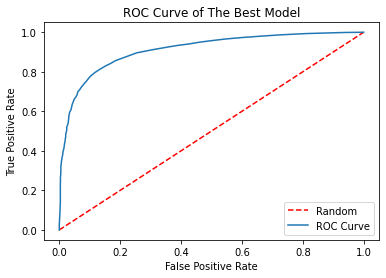

In [ ]:
# ROC curve
ROC_df = lr_pipe_2_fit.stages[-1].summary.roc.select("FPR","TPR").toPandas()

plt.plot([0, 1], [0, 1], "r--", label = "Random")
plt.plot(ROC_df.FPR, ROC_df.TPR, label = "ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of The Best Model")
plt.legend(loc = "lower right")

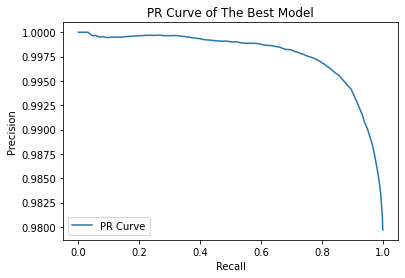

In [ ]:
# PR curve
PR_df = lr_pipe_2_fit.stages[-1].summary.pr.select("Recall", "Precision").toPandas()

plt.plot(PR_df.Recall, PR_df.Precision, label = "PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve of The Best Model")
plt.legend(loc = "lower left")

# Part 3: Products with High Rating Analysis

In [ ]:
## prediction 2
# remove irrelevent columns
df2=data_df.drop("review_summary","review_text")

# define function to extract distinct value of each column as a list
def extract_list(columnname):
  temp=df2.select(columnname).distinct().collect()
  temp=[str(row[0])for row in temp]
  return temp
body_type=extract_list("body_type")
bust_size=extract_list("bust_size")
category=extract_list("category")
fit=extract_list("fit")
rented_for=extract_list("rented_for")

# reformat rating column
df2=df2.withColumn("new_rating",when(col('rating')< 6, "low").when(col('rating')==6,"medium").otherwise('high')).drop('rating')
rating=df2.select("new_rating").distinct().collect()
rating=[str(row[0])for row in rating]

In [ ]:
print(rating)
print(fit)
print(body_type)

['low', 'high', 'medium']
['small', 'fit', 'large']
['athletic', 'full bust', 'apple', 'pear', 'petite', 'straight & narrow', 'hourglass']


In [ ]:
# build a pipeline
feature_pipe1=Pipeline(stages=[feature.StringIndexerModel.from_labels(body_type, inputCol="body_type",outputCol="body_id"),
                              feature.StringIndexerModel.from_labels(fit, inputCol="fit",outputCol="fit_id"),
                              feature.StringIndexerModel.from_labels(rating, inputCol="new_rating",outputCol="new_rating_id"),
                              feature.StringIndexerModel.from_labels(rented_for, inputCol="rented_for",outputCol="rented_id"),
                              feature.VectorAssembler(inputCols=['age', 'body_id','fit_id', 'rented_id','weights','heights'], outputCol='total_features')
                      ])

In [ ]:
# fit and transform
df2_featured=feature_pipe1.fit(df2).transform(df2)

In [ ]:
# split into training, test and validation dataset
(trainingData,testData,validationData) = df2_featured.randomSplit([0.6,0.3,0.1])

In [ ]:
# tune parameters and find the maximum F-measure score
rf=RandomForestClassifier(labelCol="new_rating_id",featuresCol="total_features")
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [6,7,8]).addGrid(rf.maxDepth, [5,6,7]).build()
all_models = []
rf_evaluator = mce(labelCol="new_rating_id", predictionCol="prediction",metricName="f1")
all_f=[]
for j in range(len(paramGrid)):
  rf_model = rf.fit(trainingData, paramGrid[j])
  all_models.append(rf_model)
  f1 = rf_evaluator.evaluate(rf_model.transform(validationData))
  all_f.append(f1)
best_model_idx = all_f.index(max(all_f))
best_model = all_models[best_model_idx]
print("The maximum F-measure score is ",max(all_f))

The maximum F-measure score is  0.8904635081254152


In [ ]:
# use the parameter set above train and test data
max_depth=best_model.getOrDefault('maxDepth')
numtrees=best_model.getOrDefault('numTrees')
best_rf=RandomForestClassifier(labelCol="new_rating_id",featuresCol="total_features",maxDepth=max_depth,numTrees=numtrees)
best_rf_model=best_rf.fit(trainingData)
rf_evaluator.evaluate(best_rf_model.transform(testData))

0.8869648978351903

In [ ]:
# print the tree structure
print(best_rf_model.toDebugString)

RandomForestClassificationModel: uid=RandomForestClassifier_13386663c477, numTrees=6, numClasses=3, numFeatures=6
  Tree 0 (weight 1.0):
    If (feature 3 in {1.0,2.0,4.0})
     If (feature 0 <= 29.5)
      If (feature 2 in {1.0})
       Predict: 1.0
      Else (feature 2 not in {1.0})
       If (feature 1 in {0.0,2.0,5.0,6.0})
        Predict: 1.0
       Else (feature 1 not in {0.0,2.0,5.0,6.0})
        If (feature 5 <= 179.07)
         Predict: 1.0
        Else (feature 5 > 179.07)
         Predict: 0.0
     Else (feature 0 > 29.5)
      Predict: 1.0
    Else (feature 3 not in {1.0,2.0,4.0})
     Predict: 1.0
  Tree 1 (weight 1.0):
    If (feature 0 <= 27.5)
     If (feature 2 in {1.0})
      Predict: 1.0
     Else (feature 2 not in {1.0})
      If (feature 4 <= 108.5)
       If (feature 2 in {0.0})
        Predict: 1.0
       Else (feature 2 not in {0.0})
        If (feature 0 <= 26.5)
         Predict: 1.0
        Else (feature 0 > 26.5)
         Predict: 2.0
      Else (feature 4 

In [ ]:
# extract feature
features = []
for i in range(6):
  features.append(best_rf_model.featureImportances[i])
imp_feature = pd.DataFrame({'features':['age', 'body_type','fit', 'rented_for','weights','heights'],\
                            'importances':features})

Text(0, 0.5, 'Feature_name')

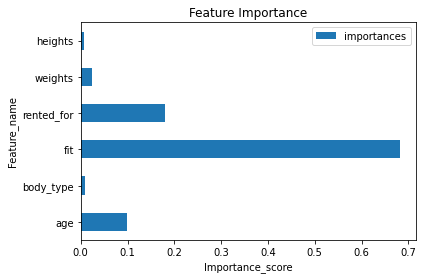

In [ ]:
# feature importance plot 
ax=imp_feature.plot(x='features',kind='barh',title='Feature Importance')
ax.set_xlabel("Importance_score")
ax.set_ylabel("Feature_name")

# Part 4: Recommendation Analysis

In [ ]:
## prediction 3
# extract useful columns from main dataframe
df4=data_df.where(col('fit')== 'fit').where(col('rating')==10)
df4=df4.select(concat_ws('_',df4.body_type,df4.bust_size,df4.category).alias('full'),'review_summary')
df4=df4.select('*',lower(col('review_summary'))).drop('review_summary').select(col('lower(review_summary)').alias('review_summary'),col('full'))

In [ ]:
# create a pipeline including tokenization, stopwordsfilter, TF-IDF, standardscaler and PCA
quotes_tokenizer = RegexTokenizer(minTokenLength=2).setGaps(False).setPattern("\\p{L}+").setInputCol("review_summary").setOutputCol("words")
#stop words
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stopwords_filter = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered")
#TF
cv = CountVectorizer(minDF=5.).setInputCol("filtered").setOutputCol("tf")
#IDF
idf = IDF().setInputCol('tf').setOutputCol('tfidf')
pipe_pca_1=Pipeline(stages=[quotes_tokenizer,stopwords_filter,cv,idf,feature.StandardScaler(withMean=True,withStd=False,inputCol='tfidf',outputCol='centered_tfidf'),feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')]).fit(df4)
chars_pca_df=pipe_pca_1.transform(df4)

In [ ]:
# show the result 
chars_pca_df.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      review_summary|                full|               words|            filtered|                  tf|               tfidf|      centered_tfidf|              scores|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|so many compliments!|hourglass_34d_romper|[so, many, compli...|       [compliments]|    (2631,[2],[1.0])|(2631,[2],[2.1323...|[-0.3742438582896...|[0.92503906745823...|
|i felt so glamour...|straight & narrow...|[felt, so, glamou...|  [felt, glamourous]|(2631,[17,930],[1...|(2631,[17,930],[3...|[-0.3742438582896...|[0.07499105501136...|
|was in love with ...|   athletic_34b_gown|[was, in, love, w...|       [love, dress]|(2631,[0,12],[1.0...|(2631,[0,12],[0.8...|[0.48540302107847...|[-

In [ ]:
# define function to compute distance 
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))
l2_dist_udf = fn.udf(l2_dist, types.FloatType())
spark.sql("SET spark.sql.crossJoin.enabled=TRUE")

DataFrame[key: string, value: string]

In [ ]:
# train a k-means model.
evaluator = ClusteringEvaluator().setFeaturesCol("scores").setPredictionCol("prediction").setMetricName("silhouette")
scores=[]
k=[]
for i in range(2,4):
  k.append(i)
  kmeans = KMeans().setK(i).setFeaturesCol("scores").setPredictionCol("prediction")
  model = kmeans.fit(chars_pca_df)
# Make predictions
  predictions = model.transform(chars_pca_df)
# Evaluate clustering by computing Silhouette score
  score=evaluator.evaluate(predictions)
  scores.append(score)

The highest silhouette score is 0.7734599744302263 and its K is 2


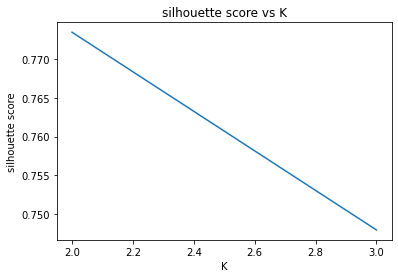

In [ ]:
# plot the data
plt.figure()
plt.plot(k, scores)
plt.title("silhouette score vs K")
plt.xlabel("K")
plt.ylabel("silhouette score")
print('The highest silhouette score is',max(scores),'and its K is',k[scores.index(max(scores))])

In [ ]:
# perform K-Means clustering using k=3
kmeans = KMeans().setK(3).setFeaturesCol("scores").setPredictionCol("prediction")
model = kmeans.fit(chars_pca_df)
predictions = model.transform(chars_pca_df)
PCAscores = np.array(predictions.select('scores').rdd.map(lambda x: x['scores']).collect())
loadings = pipe_pca_1.stages[-1].pc.toArray()
k_list=predictions.select('prediction').collect()
k_list=[int(row.prediction)for row in k_list]

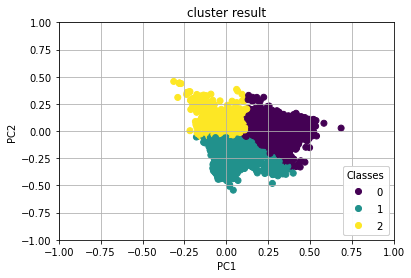

In [ ]:
# plot the cluster result
xs = PCAscores[:,0]
ys = PCAscores[:,1]
n = loadings.shape[0]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
    
x = xs * scalex
y = ys * scaley
fig,ax = plt.subplots()
sc = plt.scatter(x, y,c=k_list)
legend1 = ax.legend(*sc.legend_elements(),
                  loc="lower right", title="Classes")
ax.add_artist(legend1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("cluster result")
plt.grid()

In [ ]:
# create three different clusters
cluster_0=predictions.select('full','prediction').where(col('prediction')==0).groupBy('full').count().sort('count',ascending=False)
cluster_1=predictions.select('full','prediction').where(col('prediction')==1).groupBy('full').count().sort('count',ascending=False)
cluster_2=predictions.select('full','prediction').where(col('prediction')==2).groupBy('full').count().sort('count',ascending=False)

In [ ]:
# the result of previous action
cluster_0.show(10)

+-------------------+-----+
|               full|count|
+-------------------+-----+
|hourglass_44f_dress|  286|
| hourglass_44f_gown|  237|
| athletic_34b_dress|  220|
|hourglass_34c_dress|  212|
|hourglass_34d_dress|  211|
|  athletic_34b_gown|  194|
| athletic_34c_dress|  193|
| hourglass_34d_gown|  183|
| hourglass_34c_gown|  178|
|hourglass_34b_dress|  157|
+-------------------+-----+
only showing top 10 rows



In [ ]:
# extract several examples from clusters
cluster_0_pd=cluster_0.toPandas().rename(columns={'full':'cluster0'}).iloc[[1,3,4],]
cluster_1_pd=cluster_1.toPandas().rename(columns={'full':'cluster1'}).head(3)
cluster_2_pd=cluster_2.toPandas().rename(columns={'full':'cluster2'}).iloc[[7,8,18],]

In [ ]:
# show the result of previous action
display(cluster_0_pd)
display(cluster_1_pd)
display(cluster_2_pd)

,cluster0,count
1,hourglass_44f_gown,237
3,hourglass_34c_dress,212
4,hourglass_34d_dress,211


,cluster1,count
0,hourglass_44f_dress,496
1,athletic_34b_dress,472
2,hourglass_34d_dress,426


,cluster2,count
7,hourglass_36d_dress,976
8,hourglass_44f_gown,920
18,athletic_34d_dress,582


Text(0.5, 1.0, 'Top three for cluster0')

<Figure size 432x288 with 0 Axes>

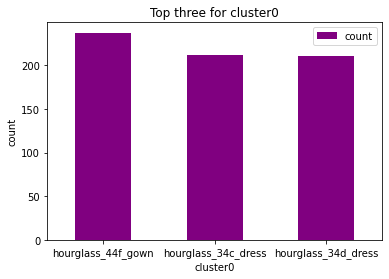

In [ ]:
# plot top 3 for cluster0
plt.figure()
p0=cluster_0_pd.plot.bar( x='cluster0',y='count',rot=0,color='purple')
p0.set_xlabel('cluster0')
p0.set_ylabel('count')
plt.xticks(rotation=0)
p0.set_title('Top three for cluster0')

Text(0.5, 1.0, 'Top three for cluster1')

<Figure size 432x288 with 0 Axes>

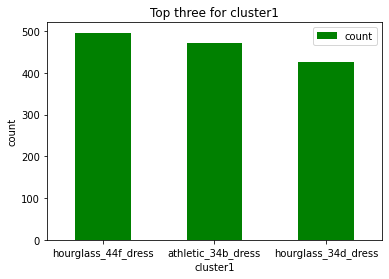

In [ ]:
# plot top 3 for cluster1
plt.figure()
p1=cluster_1_pd.plot.bar( x='cluster1',y='count',rot=0,color='green')
p1.set_xlabel('cluster1')
p1.set_ylabel('count')
plt.xticks(rotation=0)
p1.set_title('Top three for cluster1')

Text(0.5, 1.0, 'Top three for cluster2')

<Figure size 432x288 with 0 Axes>

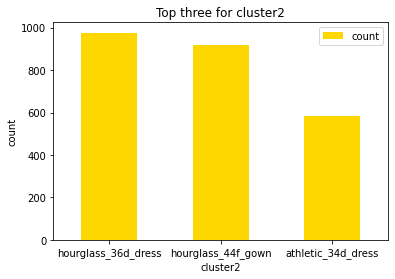

In [ ]:
# plot top 3 for cluster2
plt.figure()
p2=cluster_2_pd.plot.bar( x='cluster2',y='count',rot=0,color='gold')
p2.set_xlabel('cluster2')
p2.set_ylabel('count')
plt.xticks(rotation=0)
p2.set_title('Top three for cluster2')

# Part 5: Customer Rating Preference Analysis


In [ ]:
# prediction 4
df3 = data_df.drop('review_summary', 'review_text')
# high rating means rating is 10
df3 = df3.withColumn('rating_high', when(data_df.rating == 10, 1).otherwise(0))

In [ ]:
# create features pipeline to transform categorical variables into numerical values
feature_trans = Pipeline(
    stages = [StringIndexer(inputCol="body_type", outputCol="body_type_Num"),\
              StringIndexer(inputCol="bust_size", outputCol="bust_size_Num"),\
              StringIndexer(inputCol="category", outputCol="category_Num"),\
              StringIndexer(inputCol="rented_for", outputCol="rented_for_Num"),\
              OneHotEncoder(inputCol="body_type_Num", outputCol="body_type_Vector"),\
              OneHotEncoder(inputCol="bust_size_Num", outputCol="bust_size_Vector"),\
              OneHotEncoder(inputCol="category_Num", outputCol="category_Vector"),\
              OneHotEncoder(inputCol="rented_for_Num", outputCol="rented_for_Vector")])

# transform original dataframe
transformed_df3 = feature_trans.fit(df3).transform(df3)

In [ ]:
body_type_list = sorted(set([(i[1], i[0]) for i in transformed_df3.\
                             select(transformed_df3.body_type,\
                                    transformed_df3.body_type_Num).collect()]),\
                        key=lambda x: x[0])
bust_size_list = sorted(set([(i[1], i[0]) for i in transformed_df3.\
                             select(transformed_df3.bust_size,\
                                    transformed_df3.bust_size_Num).collect()]),\
                        key=lambda x: x[0])
category_list = sorted(set([(i[1], i[0]) for i in transformed_df3.\
                             select(transformed_df3.category,\
                                    transformed_df3.category_Num).collect()]),\
                        key=lambda x: x[0])
rented_for_list = sorted(set([(i[1], i[0]) for i in transformed_df3.\
                             select(transformed_df3.rented_for,\
                                    transformed_df3.rented_for_Num).collect()]),\
                        key=lambda x: x[0])

In [ ]:
# split training and testing data
transformed_df3 = transformed_df3.drop('body_type_Num','bust_size_Num','category_Num','rented_for_Num')
train_dt,test_dt = transformed_df3.randomSplit([0.8,0.2],seed=1)



*   **Decision Tree**


In [ ]:
# create pipeline
va = VectorAssembler(inputCols = ['body_type_Vector',\
                                  'category_Vector','rented_for_Vector',\
                                  'size','age'],\
                     outputCol='features')
sd = StandardScaler(withMean=True, inputCol='features', outputCol='centered_features')

dt = DecisionTreeClassifier(maxDepth=5, labelCol="rating_high", featuresCol="centered_features")

ppl_cv = Pipeline(stages = [va,sd,dt])

In [ ]:
# cross validation for decision tree
paramGrid = ParamGridBuilder() \
      .addGrid(dt.maxDepth, [4, 5, 6]) \
      .build()
evaluator = bce(labelCol="rating_high", rawPredictionCol="prediction",metricName= "areaUnderROC")

crossval = CrossValidator(estimator = ppl_cv,\
                            estimatorParamMaps=paramGrid,\
                            evaluator = evaluator,\
                            numFolds= 5)

cv_model = crossval.fit(train_dt)

In [ ]:
# transform testing data
dt_model = cv_model.bestModel
dt_MaxDepth = dt_model.stages[-1].getMaxDepth()
print("The max depth of decision tree is", dt_MaxDepth)
dt_predictions = dt_model.transform(test_dt)
dt_accuracy = evaluator.evaluate(dt_predictions)
print("The AUC of decision tree is", dt_accuracy)

The max depth of decision tree is 6
The AUC of decision tree is 0.5007676074167262




*   **Logistic Regression**



In [ ]:
# create pipeline
css = ChiSqSelector(featuresCol='centered_features',outputCol='Aspect',labelCol='rating_high',fpr=0.05)
lr = LogisticRegression().\
    setLabelCol('rating_high').\
    setFeaturesCol('Aspect').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

lr_estimator = Pipeline(stages = [va,sd,css,lr])

In [ ]:
# cross validation of logistic regression
lr_grid = ParamGridBuilder().\
            addGrid(lr.regParam, [0.005, 0.01]).\
            addGrid(lr.elasticNetParam, [0.01,0.05]).\
            build()

lr_cv = CrossValidator(estimator = lr_estimator,\
                            estimatorParamMaps=lr_grid,\
                            evaluator = evaluator,\
                            numFolds= 3)

lr_cv_model = lr_cv.fit(train_dt)

In [ ]:
# best model with parameters and transform testing data
lr_model = lr_cv_model.bestModel
reg_lambda = lr_model.stages[-1].getRegParam()
net_alpha = lr_model.stages[-1].getElasticNetParam()
print("The best lambda is",reg_lambda,"and the best alpha is", net_alpha)

lr_predictions = lr_model.transform(test_dt)
lr_accuracy = evaluator.evaluate(lr_predictions)
print("The AUC of logistic regression is", lr_accuracy)

The best lambda is 0.005 and the best alpha is 0.01
The AUC of logistic regression is 0.5009962537431801




*   **Gradient-boosted Tree**



In [ ]:
# create pipeline
gbt = GBTClassifier(labelCol="rating_high", featuresCol="centered_features", maxIter=10)
gbt_estimator = Pipeline(stages=[va,sd,gbt])

In [ ]:
# cross validation of gradient-boosted tree
gbt_grid = ParamGridBuilder().\
          addGrid(gbt.maxDepth, [4, 5, 6]).\
          build()

gbt_cv = CrossValidator(estimator = gbt_estimator,\
                        estimatorParamMaps=gbt_grid,\
                        evaluator = evaluator,\
                        numFolds= 5)

gbt_cv_model = gbt_cv.fit(train_dt)

In [ ]:
gbt_model = gbt_cv_model.bestModel
gbt_MaxDepth = gbt_model.stages[-1].getMaxDepth()
print("The max depth of gradient-boost tree is {}.".format(gbt_MaxDepth))
gbt_predictions = gbt_model.transform(test_dt)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("The AUC of gradient-boost tree is", gbt_accuracy)

The max depth of gradient-boost tree is 6.
The AUC of gradient-boost tree is 0.5010914388426546




*   **Model Comparison**



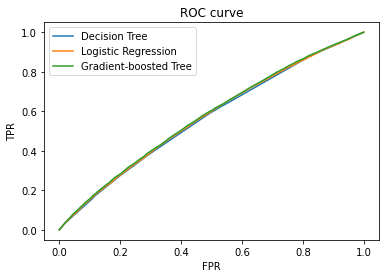

In [ ]:
# draw ROC curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics as bcm
from sklearn.metrics import roc_curve, auc

preds = dt_predictions.select('rating_high','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['rating_high']))).collect()
preds1 = lr_predictions.select('rating_high','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['rating_high']))).collect()
preds2 = gbt_predictions.select('rating_high','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['rating_high']))).collect()

fpr = dict()
tpr = dict()
fpr1 = dict()
tpr1 = dict()
fpr2 = dict()
tpr2 = dict()

y_pre = [i[1] for i in preds]
y_pro = [i[0] for i in preds]
y_pre1 = [i[1] for i in preds1]
y_pro1 = [i[0] for i in preds1]
y_pre2 = [i[1] for i in preds2]
y_pro2 = [i[0] for i in preds2]

fpr, tpr, _ = roc_curve(y_pre, y_pro)
fpr1, tpr1, _1 = roc_curve(y_pre1, y_pro1)
fpr2, tpr2, _2 = roc_curve(y_pre2, y_pro2)

plt.figure()
plt.plot(fpr, tpr,label='Decision Tree')
plt.plot(fpr1,tpr1,label='Logistic Regression')
plt.plot(fpr2,tpr2,label='Gradient-boosted Tree')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

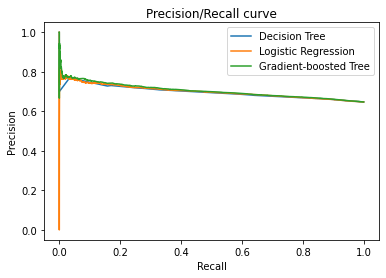

In [ ]:
# draw Precision/Recall curve
from sklearn.metrics import precision_recall_curve as prc
precision, recall, _ = prc(y_pre, y_pro)
precision1, recall1, _1 = prc(y_pre1, y_pro1)
precision2, recall2, _2 = prc(y_pre2, y_pro2)

plt.figure()
plt.plot(recall, precision,label= 'Decision Tree')
plt.plot(recall1, precision1, label= 'Logistic Regression')
plt.plot(recall2, precision2, label= 'Gradient-boosted Tree')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall curve')
plt.legend()
plt.show()

In [ ]:
# table of AUC of each model
compare_df = pd.DataFrame({'Model':['DT', 'LR', 'GBT'],'AUC':[dt_accuracy,lr_accuracy,gbt_accuracy]})
compare_df = compare_df.sort_values('AUC',ascending=False)
display(compare_df)

,Model,AUC
2,GBT,0.501091
1,LR,0.500996
0,DT,0.500768




*   **Important Features of Best Model**



In [ ]:
# select most important 10 features
feature_weights = pd.DataFrame({'index':gbt_model.stages[-1].featureImportances.indices,\
                               'weights':gbt_model.stages[-1].featureImportances.values})
feature_weights = feature_weights.sort_values('weights',ascending=False)[:10]

In [ ]:
# create data frame of important features
imp_feature = pd.DataFrame({'features':['size','party: cocktail','gown',\
                      'petite','date','sheath','pear',\
                      'everyday','work','apple'],\
               'importance':feature_weights['weights']}).\
        sort_values('importance',ascending=False)

Text(0.5, 0, 'importance score')

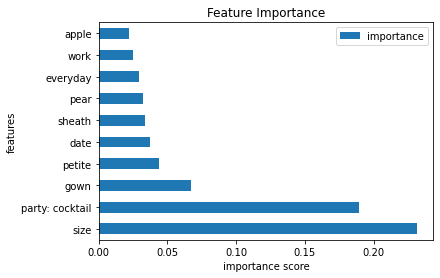

In [ ]:
# important feature visualization
fi = imp_feature.plot(x='features',kind='barh',title='Feature Importance')
fi.set_xlabel('importance score')

In [ ]:
# the structure of gradient-boosted tree
tree = gbt_model.stages[-1]
tree.toDebugString

'GBTClassificationModel: uid = GBTClassifier_8b89b142f331, numTrees=10, numClasses=2, numFeatures=83\n  Tree 0 (weight 1.0):\n    If (feature 7 <= 0.6448315785607937)\n     If (feature 82 <= -0.6768766593052999)\n      If (feature 82 <= -0.9298379640933696)\n       If (feature 77 <= 1.5418324362608973)\n        If (feature 78 <= 1.5760432419208692)\n         If (feature 81 <= -0.08777490599231322)\n          Predict: 0.4173394173394173\n         Else (feature 81 > -0.08777490599231322)\n          Predict: 0.3468269028041324\n        Else (feature 78 > 1.5760432419208692)\n         If (feature 6 <= 0.033939214243035476)\n          Predict: 0.3414043583535109\n         Else (feature 6 > 0.033939214243035476)\n          Predict: 0.18461538461538463\n       Else (feature 77 > 1.5418324362608973)\n        If (feature 81 <= 0.26519172926697976)\n         If (feature 5 <= 1.5825317000163812)\n          Predict: 0.5494505494505495\n         Else (feature 5 > 1.5825317000163812)\n          Pred